In [1]:
## install

!apt-get install xvfb
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install tf-agents-nightly
try:
  %%tensorflow_version 2.x
except:
  pass

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 783 kB in 1s (958 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.3_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.3) ...
Setting up xvfb (2:1.19.6-1ubuntu4.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 1.5MB 3.4MB/s 
  Created wheel for gym: filename

In [3]:
## setup

from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

print(tf.version.VERSION)

2.0.0


In [0]:
## hyperparameter
# num_iterations = 20000 # @param {type:"integer"}
num_iterations = 5000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-4  # @param {type:"number"}
optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate=learning_rate
)

log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

fc_layer_params = (100,50)
train_step_counter = tf.Variable(0)
collect_data_steps = 100

replay_buffer_dataset_num_steps = 2

# discout factor
# default value is set as 1.0
GAMMA = 0.6
EPSILON = 0.1

# defualt loss function
TD_ERRORS_LOSS_FN = common.element_wise_huber_loss
# TD_ERRORS_LOSS_FN = common.element_wise_squared_loss

In [34]:
## environment

env_name = 'Taxi-v2'
env = suite_gym.load(env_name)
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [0]:
## Train test environment

# This is python environment
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# But to run tf-agents, we need to convert to tensorflow environment
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [0]:
## network

# The below only set 1 hidden layer, which is 100 nodes densely connected layer
# adding other arguments to build neural network
q_net = q_network.QNetwork(
    # input_tensor_spec (DQN input is state)
    train_env.observation_spec(),
    # action_spec (DQN output is action)
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [0]:
## agent

agent = dqn_agent.DdqnAgent(
    # time_step_spec (something containing state and reward)
    train_env.time_step_spec(),
    # action_spec
    train_env.action_spec(),
    # q_network should be developed in advance, No default value
    q_network=q_net,
    # optimizer does not have default value
    optimizer=optimizer,
    # td_errors_loss_fn, default is element_wise_huber_loss, this example plays around this loss function
    td_errors_loss_fn=TD_ERRORS_LOSS_FN,
    # epsilon greedy algorithm, default is 1.0
    epsilon_greedy = EPSILON,
    # discount factor gamma, defaul is 1.0
    gamma = GAMMA,
    # counter for training
    train_step_counter=train_step_counter)

agent.initialize()

In [0]:
## policy

eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [0]:
## evaluation function

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      # Do not use the below. It use tensor objects which cause error
      # time_step = environment.step(action_step.action)
      # For step argument, we put numpy object as action integer like below
      time_step = eval_env.step(action_step.action.numpy()[0])
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [0]:
## replay buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [0]:
## function to collect data

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  # Do not use the below. It use tensor objects which cause error
  # next_time_step = environment.step(action_step.action)
  # For step argument, we put numpy object as action integer like below
  next_time_step = environment.step(action_step.action.numpy()[0])
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

In [0]:
## data collection

collect_data(train_env, random_policy, replay_buffer, steps=collect_data_steps)

In [0]:
## training dataset

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=replay_buffer_dataset_num_steps).prefetch(3)

# by next(iterator), we can get batch training data for NN
iterator = iter(dataset)

In [44]:
## training

#@test {"skip": true}
#%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 0.6179594397544861
step = 400: loss = 0.6405684947967529
step = 600: loss = 0.41907572746276855
step = 800: loss = 0.8326956033706665
step = 1000: loss = 0.23735588788986206
step = 1000: Average Return = -380.0
step = 1200: loss = 0.5850425958633423
step = 1400: loss = 0.5253002047538757
step = 1600: loss = 0.7546030879020691
step = 1800: loss = 0.6320357322692871
step = 2000: loss = 0.368532657623291
step = 2000: Average Return = -200.0
step = 2200: loss = 0.4750916361808777
step = 2400: loss = 0.6939660906791687
step = 2600: loss = 0.28559252619743347
step = 2800: loss = 0.4283487796783447
step = 3000: loss = 0.6164989471435547
step = 3000: Average Return = -200.0
step = 3200: loss = 0.48323482275009155
step = 3400: loss = 0.7699922323226929
step = 3600: loss = 0.49397414922714233
step = 3800: loss = 0.48620468378067017
step = 4000: loss = 1.0366394519805908
step = 4000: Average Return = -379.1000061035156
step = 4200: loss = 0.8320658802986145
step = 4400: loss = 

Text(0.5, 0, 'Iterations')

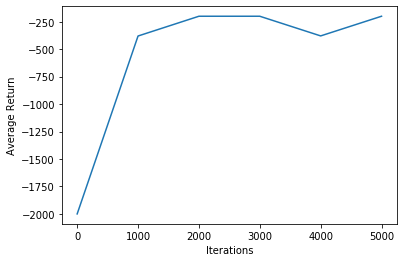

In [45]:
## visualization

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=-100)